In [34]:
!pip install emoji

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
df = pd.read_csv('sentiment_tweets3.csv')
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [37]:
df.rename(columns={'message to examine': 'Text', 'label (depression result)': 'Label'}, inplace=True)
df.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [38]:
df.shape

(10314, 3)

In [39]:
df['Text'] = df['Text'].str.lower()
df.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!! myspace.com/lookthunder,0


In [40]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Remove HTML tags from 'Text' column
df['Text'] = df['Text'].apply(remove_html_tags)

In [41]:
df.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!! myspace.com/lookthunder,0


In [42]:
# Define a function to remove URLs using regular expressions
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Apply the function to the 'Text' column
df['Text'] = df['Text'].apply(remove_urls)

In [43]:

string.punctuation

# Define the punctuation characters to remove
punctuation = string.punctuation

# Function to remove punctuation from text
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Apply remove_punctuation function to 'Text' column
df['Text'] = df['Text'].apply(remove_punctuation)

In [44]:
df.head()

,Index,Text,Label
0,106,just had a real good moment i missssssssss him...,0
1,217,is reading manga,0
2,220,comeagainjen,0
3,288,lapcat need to send em to my accountant tomorr...,0
4,540,add me on myspace myspacecomlookthunder,0


In [45]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [46]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['Text'] = df['Text'].apply(replace_chat_words)

In [47]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df['Text'] = df['Text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# Function to remove emojis from text
def remove_emojis(text):
    return emoji.demojize(text)

# Apply remove_emojis function to 'Text' column
df['Text'] = df['Text'].apply(remove_emojis)

In [49]:
# Intilize Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Apply
df['Text_lemmatized'] = df['Text'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word , pos='v') for word in x.split()]))

# Head
df.head()

,Index,Text,Label,Text_lemmatized
0,106,real good moment missssssssss much,0,real good moment missssssssss much
1,217,reading manga,0,read manga
2,220,comeagainjen,0,comeagainjen
3,288,lapcat need send em accountant tomorrow oddly ...,0,lapcat need send em accountant tomorrow oddly ...
4,540,add myspace myspacecomlookthunder,0,add myspace myspacecomlookthunder


In [50]:
X = df['Text']
y = df['Label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
tokenizer = Tokenizer(oov_token = 'nothing')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [52]:
tokenizer.document_count

10314

In [53]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 75


In [54]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[   22   652   908 ...     0     0     0]
 [   15  4059  1215 ...     0     0     0]
 [ 6280  6281     3 ...     0     0     0]
 ...
 [18977   936     0 ...     0     0     0]
 [  386  1834  5474 ...     0     0     0]
 [  409    14  1098 ...     0     0     0]]

X_test_padded:
[[18978   341   125 ...     0     0     0]
 [18979   696   182 ...     0     0     0]
 [18980    82    96 ...     0     0     0]
 ...
 [22120 22121 22122 ...     0     0     0]
 [22123   619   140 ...     0     0     0]
 [22124   626   812 ...     0     0     0]]


In [55]:
# Embedding Input Size / Vocabulary Size
input_Size = np.max(X_train_padded) + 1
input_Size

18978

In [56]:
# Define the model
model = Sequential()

# Use LSTM instead of SimpleRNN for better capturing long-term dependencies
model.add(LSTM(128, input_shape=(75,1), return_sequences=True))

# Add dropout regularization
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(LSTM(128))

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [57]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 75, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Model Train
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8013 - loss: 0.5004 - val_accuracy: 0.8429 - val_loss: 0.3793
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8548 - loss: 0.3381 - val_accuracy: 0.9113 - val_loss: 0.2011
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9283 - loss: 0.1996 - val_accuracy: 0.9535 - val_loss: 0.1281
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9412 - loss: 0.1671 - val_accuracy: 0.9627 - val_loss: 0.1021
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9686 - loss: 0.1135 - val_accuracy: 0.9699 - val_loss: 0.0877


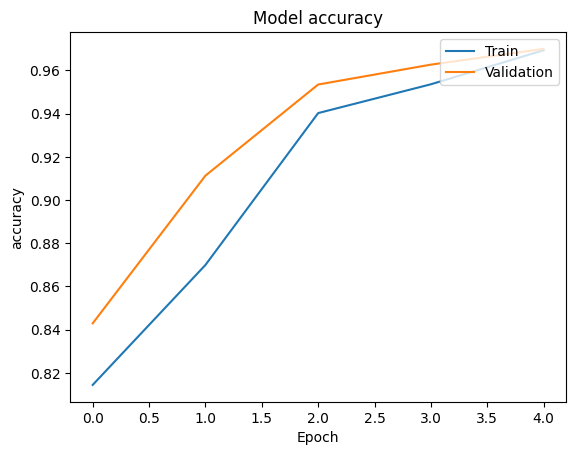

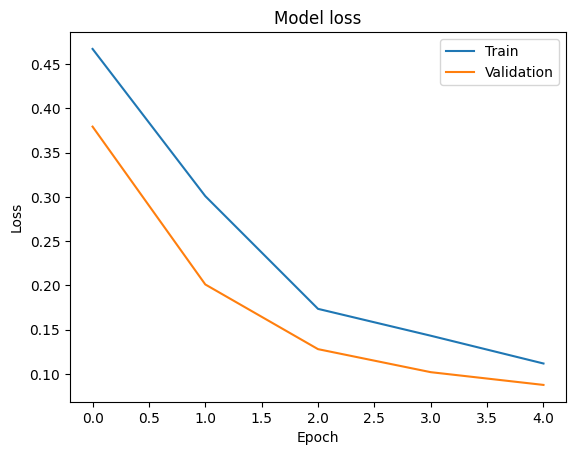

In [59]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [60]:
# Evaluate Model Performance
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Classification Report:")
print(classification_report(y_test, predictions))

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1614
           1       0.98      0.88      0.93       449

    accuracy                           0.97      2063
   macro avg       0.97      0.94      0.95      2063
weighted avg       0.97      0.97      0.97      2063



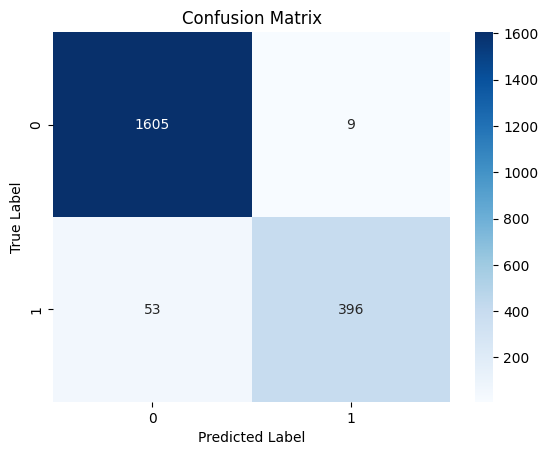

In [61]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [62]:
# Save Model
model.save("sentiment_analysis_model.h5")

In [87]:
# Load and Compile Model
from tensorflow.keras.models import load_model

loaded_model = load_model("sentiment_analysis_model.h5")
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Recompile to avoid warning

def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post')
    prediction = loaded_model.predict(padded)[0][0]
    print(f"Raw Prediction Score: {prediction:.4f}")  # Print confidence score
    return "Depressed" if prediction <= 0.0057 else "Not Depressed"

sample_text = "I am sad."
print(f"Prediction: {predict_sentiment(sample_text)}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Raw Prediction Score: 0.0057
Prediction: Depressed


In [89]:
sample_text = "I became happy after eating the ice cream."
print(f"Prediction: {predict_sentiment(sample_text)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Raw Prediction Score: 0.0060
Prediction: Not Depressed
